In [1]:
# imports

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [20]:
# read in words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# build stoi and itos mapping of all characters
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [21]:
# building the dataset

# block size is the length of the context before the next token
block_size = 3
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train / val / test split
# train is used to train the parameters
# val is used to train the hyperparameters 
# test is used to evaluate the model at the end. 
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


In [ ]:
# embedding matrix C of size 2. Embed the 27 characters to a 2 dimensional vector. 

C = torch.randn((27, 2))

# really easy way of pytorch indexing
# shape of (32, 3, 2)
emb = C[Xtr]
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
# hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

# -1 tells Pytorch to infer what that dimension should be, in this case it has to be 32
# in torch, each torch vector is stored together, so when you do view and reshape, it does not recreate storage
# thus, do not want to use .cat or .unbind because those create new storage which is highly inefficient
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

torch.Size([228146, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2

# always use cross_entropy instead of manually calculating the nll 
# 1. because for every manual step you would create new tensors and the calculations using this function 
# can be done with a fused kernel that is more efficient. tldr: forward pass is more efficient
# 2. Also, the backpropagation for this is much more efficient because this is treated as one step, 
# and there are analytical speedups. tldr: backward pass is more efficient
# 3. If you have a very large valued logit, the exponentiation of that value will become really large, 
# resulting in inf values and overflow. To fix this, PyTorch internally calculates the largest value
# of the logits, and subtracts it from all the logits because small logits are ok. This works because
# the add constant terms cancels in softmax. tldr: numerically stable. 

loss = F.cross_entropy(logits, Y)
loss

tensor(57.4183)

In [5]:
# combining it all together

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10))
W1 = torch.randn((30, 200))
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [ ]:
# learning rate scheduler
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
# lri = []

In [6]:
lossi = []

In [16]:

for k in range(50000):
    # construct minibatch, so that we don't do forward pass on the whole dataset
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])
    print(k, loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # lri.append(lre[k])
    lossi.append(loss.log10().item())

0 2.021890640258789
1 1.9693626165390015
2 2.259808301925659
3 2.0871076583862305
4 2.050041437149048
5 1.9422084093093872
6 1.8954453468322754
7 2.7066357135772705
8 2.3435144424438477
9 2.3508307933807373
10 2.0623862743377686
11 2.0308666229248047
12 2.117642879486084
13 2.4104506969451904
14 1.9079948663711548
15 2.0496504306793213
16 2.050748348236084
17 2.2804903984069824
18 1.9100884199142456
19 1.8781706094741821
20 2.2843570709228516
21 2.0602869987487793
22 2.393749952316284
23 1.6005470752716064
24 2.3632113933563232
25 2.266509771347046
26 2.0627315044403076
27 2.2118983268737793
28 1.899510145187378
29 2.23553204536438
30 1.9879400730133057
31 1.7639172077178955
32 2.248429775238037
33 2.2911624908447266
34 2.319152355194092
35 2.2147631645202637
36 2.1390693187713623
37 1.8346915245056152
38 2.056396722793579
39 1.9657325744628906
40 1.7941454648971558
41 2.232396125793457
42 2.3514273166656494
43 2.17104434967041
44 2.1610677242279053
45 1.9579708576202393
46 2.476564168

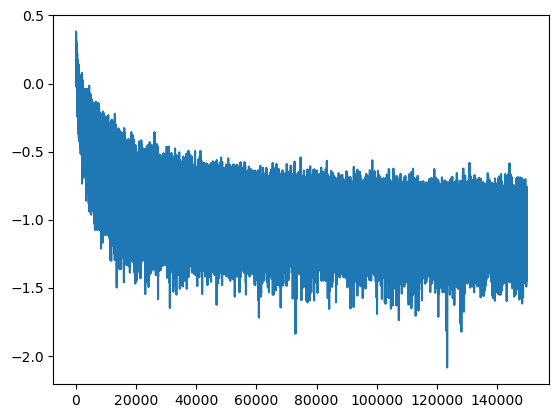

In [11]:
# visualizing the loss curve
plt.plot(torch.arange(150000), torch.tensor(lossi).log())

In [17]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1777, grad_fn=<NllLossBackward0>)

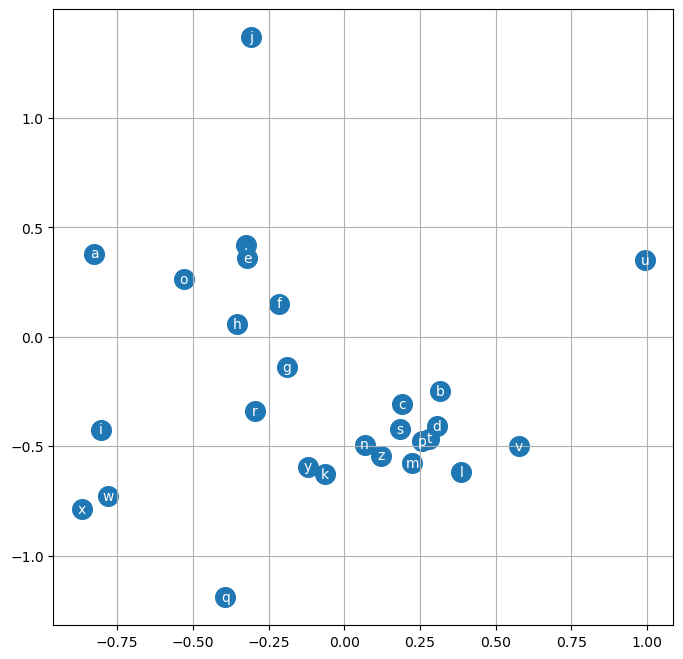

In [ ]:
# visualizing the 2D character embedding
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
# plt.axis('off')

In [25]:
# sampling from our model

for _ in range(20):
    out = []
    context = [0 ]* block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

layladalinlo.
abiyah.
mikkinganley.
aleeyaan.
kerbente.
kalha.
ani.
evmadon.
xioa.
valee.
zaylynn.
laylin.
ashaniulah.
ana.
beladrysen.
mika.
zuri.
kailyna.
naz.
quinleeawuadeyliella.
